# Retrieving OpenStreetMap data


## What is OpenStreetMap?

[OpenStreetMap](www.openstreetmap.org) [^OSM] (OSM) is a free, editable  map of the world that is created by a global community of mappers. OSM is often referred to as "the Wikipedia of maps" meaning that anyone can update the contents and use them freely. When using OSM data, appropriate credit should be given to OpenStreetMap and its contributors (see [OSM Copyright and License](https://www.openstreetmap.org/copyright) [^OSM_license]). 

OpenStreetMap data are increasingly used in various map-based applications and as research data. In many regions, OSM is the best data available on streets, buildings and amenities, or at least the best data source that is openly available. OSM data are often most complete from urban regions as many public transport organizations and companies also update the map to improve their services. Various organized mapping campaings exists to update OSM in areas that lack detailed map data (check out [Humanitarian OpenStreetMap Team](https://www.hotosm.org) [^HOTOSM]).

For geographic data analysis, OSM may be used as source data for various tasks such as routing and geocoding, and as bacground maps for visualizing analysis results. [The Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) [^Overpass_API_intro] can be used for querying and fetching data for further analysis. Relevant map feature categories include: 

- street networks
- buildings
- amenities
- landuse
- natural elements
- boundaries

In OpenStreetMap, different types of map features are labeled using tags, which consist of a key which describes the category (such as "highway" or "building") and a value, which describes the type of object within the category (such as "primary road" or "aparment"). Information on various map features and their associated tags is fundamental for correctly using the data. 

A good way to start working with OSM data is to view the map from an area you are familiar with and inspect the map features and their tags. The great thing about OSM is that anyone can sign up and make edits to the map. There are various discussion forums and mapping projects that support new (and old) mappers. [The OSM wiki](https://wiki.openstreetmap.org/wiki/Main_Page) [^OSM_wiki] provides an extensive overview for anyone planning to use or produce OSM data. 


#### Question 9.1

Go to www.openstreetmap.org and zoom the map to an area that you are familiar with. 
- Does the map look complete?
- Are there any geometric features (roads, buildings, bus stops, service locations) missing?
- Inspect further some of the features; are there any attribute information missing (street names, building addresses, service names or opening hours)?

You can check the intended tags for various map freatures from the [OSM wiki](https://wiki.openstreetmap.org/wiki/Map_features) [^OSM_wiki_tags]. If you spotted some missing information, freel free to create an OpenStreetMap account, log in, and update the map!

## Downloading OpenStreetMap data with OSMnx

[Osmnx](https://github.com/gboeing/osmnx) [^OSMnx] is a Python package that makes it easy to download, model and analyze street networks and other geospatial features from OpenSteetMap ({cite}`Boeing2024`). `Osmnx` relies on `geopandas` and another module called `networkx`, which enables network analysis. For latest updates, installation instructions, and complete user reference, see [osmnx  documentation](https://osmnx.readthedocs.io/en/stable/index.html) [^osmnx_docs]. 

### Defining the area of interest

In [1]:
import osmnx as ox

In [2]:
place = "Kamppi, Helsinki, Finland"

# ADD CODE FOR DOWNLOADING THE AOI POLYGON

### Street network

Street networks are downloaded using the `osmnx` `graph` module which can be used to retrieve the street network data and to construct a `networkx` graph model that can be used for routing. 

In [3]:
# Fetch OSM street network from the location
graph = ox.graph_from_place(place)

Let's check the type of data we got: 

In [4]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

Let's have a closer look a the street nework. OSMnx has its own function [plot_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=plot_graph#osmnx.plot.plot_graph) for visualizing graph objects. The function utilizes Matplotlib for visualizing the data,
hence as a result it returns a matplotlib figure and axis objects:


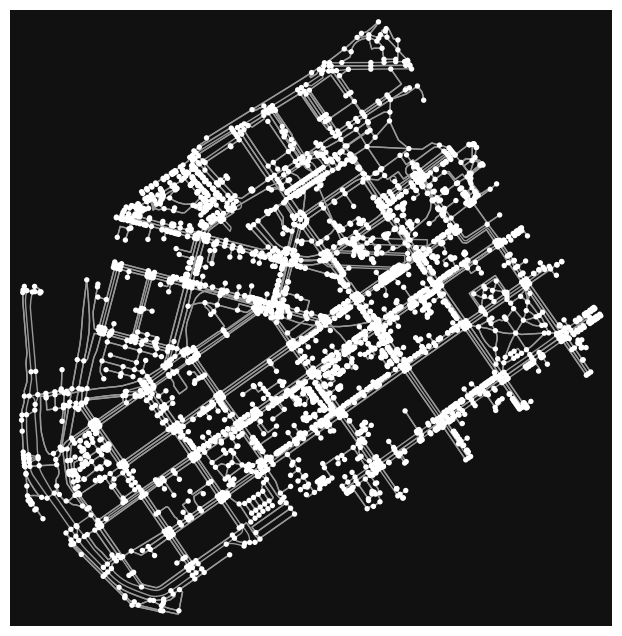

In [5]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

From here we can see that our graph contains nodes (the points) and edges (the lines) that connects those nodes to each other. For now, we won't dive deeper into routing analysis, but you can find further examples from the `osmnx` online documentation. 

Instead, we can convert the streets (edges of the network) into a `GeoDataFrame` using the `osmnx` function `graph_to_gdfs()`. 

In [6]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [7]:
edges.head(2)

osmid  highway lanes maxspeed            name  \
u        v          key                                                     
25216594 1372425721 0    23717777  primary     2       40   Porkkalankatu   
         1372425714 0    23856784  primary     2       40  Mechelininkatu   

                         oneway reversed     length  \
u        v          key                               
25216594 1372425721 0      True    False  10.403735   
         1372425714 0      True    False  40.885163   

                                                                  geometry  \
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)   
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   

                        junction width tunnel access service bridge  
u        v          key                                              
25216594 1372425721 0        NaN   NaN    NaN    NaN     NaN    NaN  
         1372425714 0        NaN   NaN    NaN    NaN     NaN    NaN

### Other map features
Downloading building footprints, points of interests such as services and other map features is possible using the `osmnx` `features` module.  Map queries can be defined by city name, polygon, bounding box or an address or a point location and a buffer distance. In addition, a set of tags can be specified to select which map features to download. Tags are passed to these functions as a dictionary allowing querying multiple tags at the same time.There are different functions available to query data from the Overpass API using `osmnx` depending on the way in which the spatial location is defined: 

- address: [osmnx.features.features_from_address(address, tags, dist)](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_address)
- bounding box: [osmnx.features.features_from_bbox(bbox, tags)](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_bbox)
- place: [osmnx.features.features_from_place(place, tags)](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place)
- point: [osmnx.features.features_from_point(center_point, tags, dist)](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_point)
- polygon: [osmnx.features.features_from_polygon(polygon, tags)](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon)

These functions return a `GeoDataFrame` object.  Here, we will demonstrate the use of a place name search for downloading and visualizing OSM data for a central urban area in Helsinki, Finland.

In [8]:
place = "Kamppi, Helsinki, Finland"
tags = { "building" : True}

buildings = ox.features.features_from_place(place, tags)

Notice that the  place name and an associated polygon should exist on OpenStreetMap, otherwise the query will fail. The downloaded OSM data comes with plenty of information representing various attributes of the features that OSM contributors have added. Each column in the data contains information about a spesific tag that OpenStreetMap contributors have added. At the time of writing, the building data from central Helsinki containe 120 different columns.

In [9]:
len(buildings.columns)

120

You can see names of all available columns, for example, by running `list(buildings.columns)`. Let's check the contents of some of the available columns:

In [10]:
buildings[['building', 'name', 'addr:city', 'geometry']].head()

building                   name addr:city  \
element id                                                      
node    11711721042      yes  Nice Bike Pyörähuolto  Helsinki   
way     8035238       public            Lasipalatsi  Helsinki   
        8042297          yes     Radisson Blu Royal  Helsinki   
        14797170      school                    NaN       NaN   
        14797171         yes                    NaN       NaN   

                                                              geometry  
element id                                                              
node    11711721042                           POINT (24.92714 60.1642)  
way     8035238      POLYGON ((24.93563 60.17045, 24.93557 60.17054...  
        8042297      POLYGON ((24.92938 60.16795, 24.92933 60.16797...  
        14797170     POLYGON ((24.92427 60.16648, 24.92427 60.1665,...  
        14797171     POLYGON ((24.9239 60.16729, 24.92391 60.16731,...


From here we can tell that some, but not all of the buildings have a more specific information of the type of building (e.g., a school) and name and address. Let's plot the building footprints to get an overview of the data. While plotting,` we can add color the map according to the building tag values to get an overview of where different types of buildings are located. Notice that some buildings are tagged only with the generic tag "building=yes" without further information about the type of the building.

<Axes: >

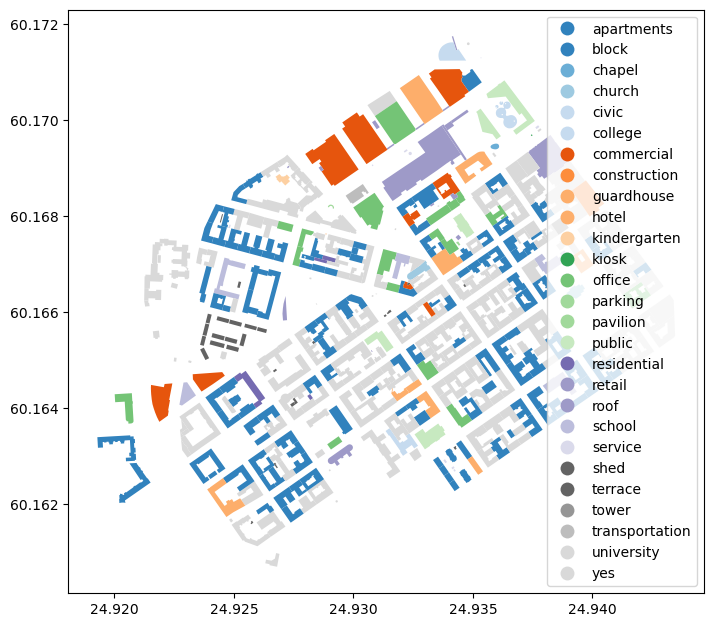

In [11]:
buildings.plot(column="building", figsize=(8.2,8), cmap="tab20c", legend=True)

### Amenities

Continuing with the same place, let's also fetch all points of interests using the amenity tag:

In [12]:
tags = {"amenity": True}
amenities = ox.features.features_from_place(place, tags)

Again, let's only plot a couple of available columns to check the contents of the data. You can see all column names  by running `list(buildings.columns)`.

In [13]:
amenities[['amenity', 'name', 'opening_hours', 'addr:city', 'geometry']].head()

amenity                     name  \
element id                                              
node    60062502  restaurant                   Kabuki   
        60068035        cafe                Cafe Java   
        62965963  restaurant  Restaurant & Bar Fusion   
        76617692  restaurant             Johan Ludvig   
        76624339  restaurant                  Shinobi   

                                                      opening_hours addr:city  \
element id                                                                      
node    60062502                                                NaN  Helsinki   
        60068035  Mo-Tu 09:00-21:00; We-Th 09:00-22:00; Fr 09:00...  Helsinki   
        62965963                 Mo-Th 11-22; Fr-Sa 11-02; Su 12-20       NaN   
        76617692                                                NaN  Helsinki   
        76624339               We-Th 17:00-23:00; Fr-Sa 16:00-24:00  Helsinki   

                                   geometry  
element id                                   
node    60062502  POINT (24.92422 60.16725)  
        60068035  POINT (24.93752 60.16997)  
        62965963  POINT (24.93292 60.16953)  
        76617692  POINT (24.92913 60.16781)  
        76624339  POINT (24.93194 60.16508)

Here, we received all amenities in the area of interest ranging from restaurants, cafes and so on. The type of amenity (i.e. the value of the OSM tag) is indicated in the `amenity` column. Again, some, but not all features have additional information such as opening hours available. The downloaded data contains more than 700 individual points of interests in the data:

In [14]:
len(amenities)

757

#### Question 9.2

How many different amenity categories are there?

In [15]:
# Use this cell to enter your solution.

In [16]:
# Solution

# Get number of unique values in column `amenity`
amenities["amenity"].nunique()

63

Let's limit our query to contain only restaurants and cafes in our area of interest. We can do this by specifying one or several tag values in the dictionary.

In [17]:
tags = {"amenity" : ["restaurant", "cafe"]}
amenities = ox.features.features_from_place(place, tags)

In [18]:
len(amenities)

214

### Green space

Urban green space and public open space are vital components of liveable urban areas. Let's see how we can fetch urban green space data from OSM using the `osmnx` `features` module. Fetching green spaces from OpenStreetMap requires a bit of investigation of appropriate tag values - these might vary across cities. One common way of tagging urban parks is `leisure=park`. If wanting to capture also other green infrastructure, additional tags such as `landuse=grass` may be added. Let's proceed with these two tags that should capture rather well the available greenspaces in downtown Helsinki.

In [19]:
# List key-value pairs for tags
tags = {"leisure": "park", "landuse": "grass"}

In [20]:
# Get the data
parks = ox.features.features_from_place(place, tags)

In [21]:
# Check number of downloaded objects
print("Retrieved", len(parks), "objects")

Retrieved 121 objects


let's check the first rows:

In [22]:
parks[['leisure', 'landuse', 'name', 'geometry']].head()

leisure landuse                    name  \
element id                                                 
way     8042256     park     NaN  Pikkuparlamentinpuisto   
        8042613     park     NaN          Simonpuistikko   
        15218362    park     NaN      Työmiehenpuistikko   
        15218739    park     NaN             Lastenlehto   
        15223911    park     NaN   Lapinlahden puistikko   

                                                           geometry  
element id                                                           
way     8042256   POLYGON ((24.93566 60.17132, 24.93566 60.1713,...  
        8042613   POLYGON ((24.93701 60.16947, 24.93627 60.16919...  
        15218362  POLYGON ((24.9233 60.16499, 24.92323 60.165, 2...  
        15218739  POLYGON ((24.92741 60.16575, 24.92741 60.16574...  
        15223911  POLYGON ((24.93126 60.16589, 24.93075 60.16624...

The first five rows of data contain different parks, which all have a name. Let's quicly plot the data to see the geometry:

<Axes: >

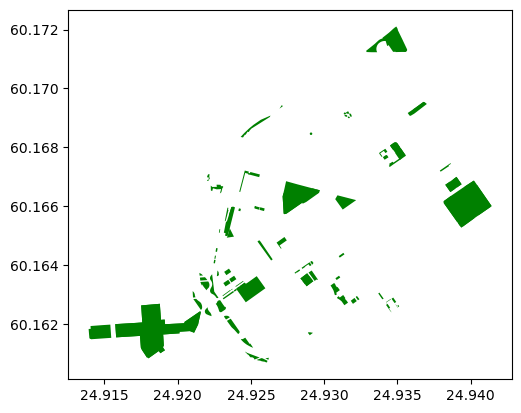

In [29]:
parks.plot(color="green")

### Plotting the data

Let's create a map out of the streets, buildings, restaurants in our area of interest.

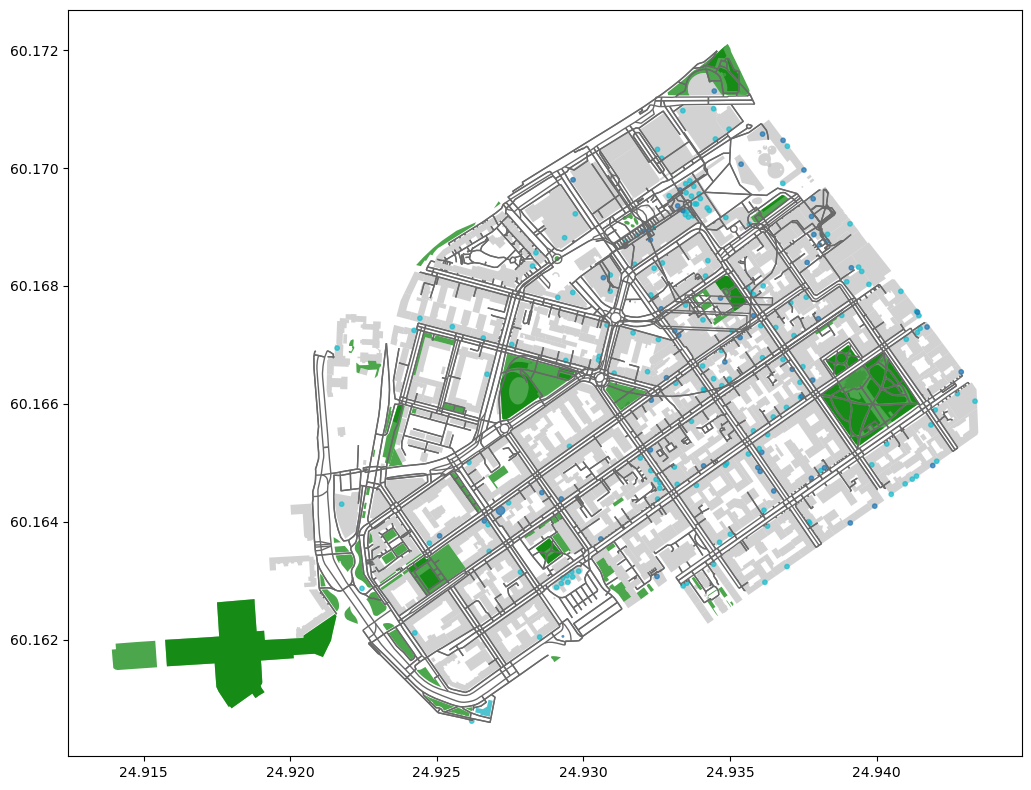

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the footprint
#area.plot(ax=ax, facecolor="black")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

# Plot buildings
buildings.plot(ax=ax, facecolor="silver", alpha=0.7)

parks.plot(ax=ax, facecolor="green", alpha=0.7)

# Plot restaurants
amenities.plot(ax=ax, column="amenity", alpha=0.7, markersize=10)

plt.tight_layout()

Cool! Now we have a map where we have plotted the restaurants, buildings, streets and the boundaries of the selected region of 'Kamppi' in Helsinki. And all of this required only a few lines of code. Pretty neat! 


#### Question 9.3

Check your understanding and retrieve OpenStreetMap data from some other area in the world. Use `osmnx`and download:

- Polygon of your area of interest
- Street network
- Building footprints
- Restaurants and cafes (or why not also other amenities)
- Green spaces

*Note, the larger the area you choose, the longer it takes to retrieve data from the API! Use parameter `network_type=drive` to limit the graph query to filter out un-driveable roads.*

In [26]:
# Use this cell to enter your solution.

In [27]:
# Solution

# INSERT EXAMPLE SOLUTION HERE
#streets = 
#builginds = 
#amenities =
#parks = 

NameError: name 'area' is not defined

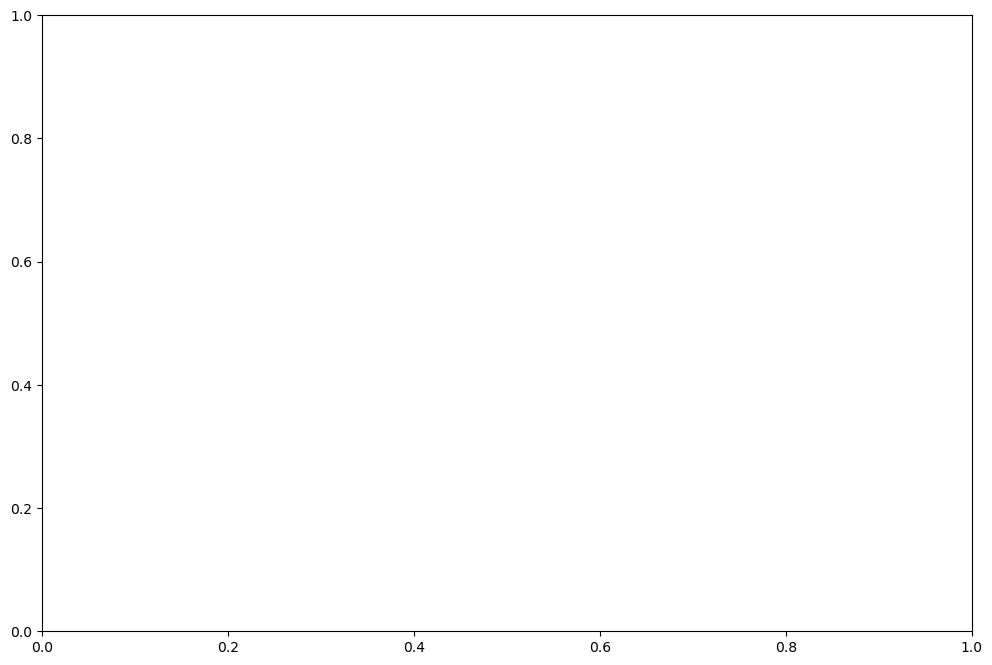

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the footprint
area.plot(ax=ax, facecolor="black")

# Plot the parks
parks.plot(ax=ax, facecolor="green")

# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor="dimgray")

# Plot buildings
buildings.plot(ax=ax, facecolor="silver", alpha=0.7)

# Plot restaurants
restaurants.plot(ax=ax, color="yellow", alpha=0.7, markersize=10)
plt.tight_layout()

## Footnotes

[^OSM]: <https://www.openstreetmap.org/>
[^OSM_license]: <https://www.openstreetmap.org/copyright>
[^Overpass_API_intro]: <https://wiki.openstreetmap.org/wiki/Overpass_API> 
[^HOTOSM]: <https://www.hotosm.org> 
[^OSM_wiki]: <https://wiki.openstreetmap.org/wiki/Main_Page>
[^OSM_wiki_tags]: <https://wiki.openstreetmap.org/wiki/Map_features> 
[^OSMnx]: <https://github.com/gboeing/osmnx>
[^osmnx_docs]: <https://osmnx.readthedocs.io/en/stable/index.html>